In [1]:
from config import *
from utils import *

import os
import sys
import copy
import numpy as np
import collections
import multiprocessing
import pickle

import numpy as np
import scipy

# Suppress pandas future warning, which messes tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import pairwise2

# Check for inDelphi training data leakage
inDelphi (Shen et al. 2018) is trained on a dataset of 55-bp sequences (available from their [GitHub](https://github.com/maxwshen/indelphi-dataprocessinganalysis/blob/master/SupplementaryData.xlsx)), referred to as "lib-A" in its paper. We are evaluating the performance of inDelphi on our lib-SA library of 61-bp sequences (specifically, the dat-A subset). For the evaluation to be meaningful, we need to make sure inDelphi lib-A sequences do not overlap and are not homologous to sequences from our dat-A.

## inDelphi's Lib-A

In [2]:
libA_df = pd.read_excel(os.path.join(DATA_DIR, 'indelphiLibA', 'SupplementaryData.xlsx'), header=1, sheet_name='Supplementary Table 2')

In [3]:
libA_df.head()

,Index number,Name,gRNA,Sequence Context,SpCas9 PAM,"Total readcount, mESCs","Total number of unique high-confidence outcomes, mESCs","Total readcount, U2OS cells","Total number of unique high-confidence outcomes, U2OS cells"
0,0,0_0_0_0,CTTTCACTTTATAGATTTAT,GTGCTCTTAACTTTCACTTTATAGATTTATAGGGTTAATAAATGGG...,AGG,5498.984841,31,501.000000,1
1,1,0_0_0_0,AATCCTCTAAATAGTTAAAT,CCTTTGTACCAATCCTCTAAATAGTTAAATAGGAAGGATAACCCAA...,AGG,30592.535156,62,5931.267377,13
2,2,0_0_0_0,AAATATCTTTAACCTAAAAC,GTAAAAGTTAAAATATCTTTAACCTAAAACCGGGTTCAGCGACTTA...,CGG,13346.723123,42,524.000000,3
3,3,0_0_0_1,TGTCATCTTTATGCTTAAAG,ACTGTTAAATTGTCATCTTTATGCTTAAAGAGGCTTAAGTTACTTC...,AGG,197322.665139,206,14094.000000,10
4,4,0_0_0_1,TTTAAGCACAGCAAGGCTCT,GATATTATAATTTAAGCACAGCAAGGCTCTTGGCTAGAATTATACC...,TGG,129094.351837,121,15887.000000,24


In [4]:
libA_seqs = libA_df['Sequence Context'].unique().tolist()

In [5]:
len(libA_seqs)

1998

## Our dat-A Target Sequences

In [6]:
exp_design.head() # lib-SA

,Azimuth score,Cas type,Cutsite within sequence,"Designed 61-bp target site (37i-24e, AG)","Designed 61-bp target site (37i-24e, CT reverse-complement)","Designed gRNA (NGG orientation, 19 and 20)",Has AG,MaxEntScan AG disruption frequency in MH dels and insertions genomic_context,MaxEntScan AG disruption frequency in MH dels and insertions library_context,Ontarget score,...,inDelphi Precision library_context,inDelphi expected indel length genomic_context,inDelphi expected indel length library_context,inDelphi highest outcome frequency genomic_context,inDelphi highest outcome frequency library_context,inDelphi logphi genomic_context,inDelphi logphi library_context,strand,total_vars,Designed gRNA (NGG orientation)
Identifier number,,,,,,,,,,,,,,,,,,,,,
2,0.685572,SpCas9,68,GGAAATGCCCTGCCTAAGCTTTGGGTGCCCCCTGCAGTCCTGACCT...,GCAGGATGATGATCCAGGTCAGGACTGCAGGGGGCACCCAAAGCTT...,ATCCAGGTCAGGACTGCAGG,yes,0.796188,0.796141,0.858865,...,0.426247,7.552535,7.546523,16.796109,16.798237,-2.441151,-2.441337,+,12,GATCCAGGTCAGGACTGCAGG
3,0.666555,SpCas9,69,GGAAATGCCCTGCCTAAGCTTTGGGTGCCCCCTGCAGTCCTGACCT...,GCAGGATGATGATCCAGGTCAGGACTGCAGGGGGCACCCAAAGCTT...,ATCCAGGTCAGGACTGCAG,yes,0.760537,0.760490,0.844692,...,0.527270,8.262278,8.256890,37.627192,37.633988,-2.109904,-2.110079,+,12,TGATCCAGGTCAGGACTGCAG
4,0.621866,SpCas9,70,GGAAATGCCCTGCCTAAGCTTTGGGTGCCCCCTGCAGTCCTGACCT...,GCAGGATGATGATCCAGGTCAGGACTGCAGGGGGCACCCAAAGCTT...,TGATCCAGGTCAGGACTGCA,yes,0.793351,0.793299,0.854025,...,0.572962,6.545344,6.540914,28.429830,28.436377,-2.139149,-2.139360,+,12,ATGATCCAGGTCAGGACTGCA
5,0.434994,SpCas9,71,GGAAATGCCCTGCCTAAGCTTTGGGTGCCCCCTGCAGTCCTGACCT...,GCAGGATGATGATCCAGGTCAGGACTGCAGGGGGCACCCAAAGCTT...,ATGATCCAGGTCAGGACTGC,yes,0.699063,0.698923,0.781274,...,0.523115,8.410657,8.406734,37.406834,37.408835,-2.126282,-2.126381,+,12,GATGATCCAGGTCAGGACTGC
6,0.535781,SpCas9,68,TGCCAGGCATGCCCACTGACTGGTGCCCTTGGCCCAGGGTGGAGAC...,AGTATTGGAATGAAGGTCTCCACCCTGGGCCAAGGGCACCAGTCAG...,TGACTGGTGCCCTTGGCCCA,yes,1.000000,1.000000,0.860908,...,0.443413,7.775675,7.788979,10.368532,10.361942,-2.355018,-2.354383,+,14,CTGACTGGTGCCCTTGGCCCA


In [7]:
datA_df = pd.read_csv(os.path.join(TABLES_DIR, 'datA_table.csv.gz'), compression='gzip')
datA_df

,gRNA ID,Category,Genotype position,Inserted Bases,Length,Empirical frequency,Predicted frequency
0,8495,ins,NaN,A,1,0.018119,0.009339
1,8495,ins,NaN,G,1,0.000000,0.001777
2,8495,ins,NaN,T,1,0.000211,0.004559
3,8495,ins,NaN,C,1,0.049616,0.070707
4,8495,del,0.0,NaN,1,0.167597,0.032842
...,...,...,...,...,...,...,...
3210325,3256,del,56.0,NaN,60,0.000000,0.000000
3210326,3256,del,57.0,NaN,60,0.000000,0.000000
3210327,3256,del,58.0,NaN,60,0.000000,0.000000
3210328,3256,del,59.0,NaN,60,0.000000,0.000000


In [8]:
datA_seqs = exp_design.loc[datA_df['gRNA ID'].unique()]['Designed 61-bp target site (37i-24e, AG)'].unique().tolist()

In [9]:
len(datA_seqs)

1549

## Sequence Identity Analysis
For each target sequence in our dat-A, align it with every sequence in inDelphi's lib-A to determine the most similar sequence, and record the sequence identity. Plot distribution of such max sequence identities. If lib-SA sequences are dissimilar to inDelphi's lib-A sequences, then the distribution should be skewed towards lower max sequence identities.

Local alignment (Smith Waterman) parameters: +1 match, -3 mismatch, -5 gap open, -2 gap extend. These are the same as the default parameters of BLAST's blastn-short program.

Sequence identity is the definition used by BLAST: (# match positions in alignment(seq1, seq2))/(min(len(seq1), len(seq2))

In [10]:
def sequence_identity(seq1, seq2, alignment):
    num_matches = pairwise2.format_alignment(*alignment).split('\n')[1].count('|')
    return num_matches / min(len(seq1), len(seq2))

In [11]:
def max_seq_identity_libA(our_seq):
    max_seq_identity = -1
    for inDelphi_seq in libA_seqs:
        # Using BLAST suite's blastn-short defaults:
        # +1 match
        # -3 mismatch
        # -5 gap open
        # -2 gap extend
        alignment = pairwise2.align.localms(inDelphi_seq, our_seq, 1, -3, -5, -2)
        identity = sequence_identity(inDelphi_seq, our_seq, alignment[0])
        max_seq_identity = max(max_seq_identity, identity)
    return max_seq_identity

def compute_max_sequence_identities():
    max_sequence_identities = []
    
    try:
        p = multiprocessing.Pool(NUM_PROCESSES)
        for max_seq_identity in tqdm(p.imap_unordered(max_seq_identity_libA, datA_seqs, chunksize=2), total=len(datA_seqs)):
            max_sequence_identities.append(max_seq_identity)
    finally:
        p.close()
        p.join()
        
    return max_sequence_identities

In [12]:
if not pickle_exists(DAT_A_INDELPHI_SEQUENCE_IDENTITY):
    max_sequence_identities = compute_max_sequence_identities()
    save_var(max_sequence_identities, DAT_A_INDELPHI_SEQUENCE_IDENTITY)
else:
    max_sequence_identities = load_var(DAT_A_INDELPHI_SEQUENCE_IDENTITY)

## S2 FigA

In [13]:
def plot_max_sequence_identities(max_sequence_identities):
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize=(5,5))
    sns.distplot(max_sequence_identities, kde=False, ax = ax)
    ax.set(xlabel="Sequence Identity",
           ylabel='# of dat-A Target Sequences (' + str(len(datA_seqs)) + ' Total)',
           title="Distribution of pairwise best aligned\nsequence identity\nbetween dat-A & inDelphi's Lib-A")
    median = np.median(max_sequence_identities)
    plt.axvline(median, color='gray', linestyle='dotted')
    plt.text(median + 0.01, 450, 'Median = ' + "{:.2f}".format(median))
    plt.savefig(os.path.join(IMAGES_DIR, 'datA_indelphi_sequence_identity.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("Median sequence identity:", np.median(max_sequence_identities))
    print("Mean sequence identity:", np.mean(max_sequence_identities))
    print("Min sequence identity:", np.min(max_sequence_identities))
    print("Max sequence identity:", np.max(max_sequence_identities))
    print("Second largest sequence identity:", np.sort(max_sequence_identities)[::-1][1])

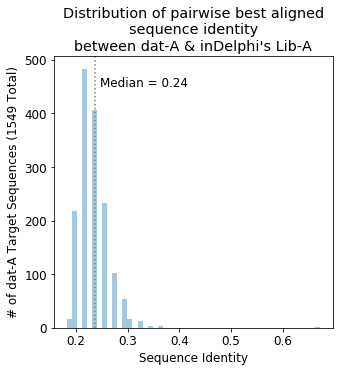

Median sequence identity: 0.23636363636363636
Mean sequence identity: 0.2343447385409942
Min sequence identity: 0.18181818181818182
Max sequence identity: 0.6727272727272727
Second largest sequence identity: 0.36363636363636365


In [14]:
plot_max_sequence_identities(max_sequence_identities)